In [1]:
from boruta import BorutaPy
import numpy as np 
from scipy.stats import chi2
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def make_dataset_1(p, k, n): 
    X = np.random.normal(size=(n, p))
    Y = ((X[:, :k]**2).sum(axis=1) > chi2.ppf(0.5, k)).astype(np.int32)
    return X, Y
    
def make_dataset_2(p, k, n): 
    X = np.random.normal(size=(n, p))
    Y = ((np.abs(X[:, :k])).sum(axis=1) > k).astype(np.int32) 
    return X, Y

x_1, y_1 = make_dataset_1(n=500, p=50, k=10)
x_2, y_2 = make_dataset_2(n=500, p=50, k=10)


- Check if the considered algorithms assign the highest variable importance scores to the significant variables.
    - Variable importance measures based on Random Forest.
    - Boruta algorithm (you can use R package Boruta).

In [3]:
def return_top_k_features(X, Y, k, method):
    if method == 'RandomForest':
        feature_names = np.arange(k)
        forest = RandomForestClassifier()
        forest.fit(X, Y)
        importances = forest.feature_importances_
        indices = np.argpartition(importances, -k)[-k:]
        return np.sort(indices)
    elif method == 'Boruta': 
        rf = RandomForestClassifier(n_jobs=-1)
        feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0)
        feat_selector.fit(x_1, y_1)
        indices = np.arange(len(feat_selector.support_))[feat_selector.support_]
        return indices
    else: 
        raise ValueError(f"Incorrect method: {method}")

In [ ]:
results = []

In [13]:
L = 5
ns = [100,200,500,1000]
#ns = [100, 200]
ps = [10,20,50, 100]
#ps = [10, 20]
ks = [10, 15, 20, 50]
#ks = [5, 15]
results_already_done = {row[:-1] for row in results}
for n in ns:
    print(f'n: {n}')
    for p in ps: 
        print(f'p: {p}')

        for k in ks: 
            if k>p: 
                continue
            true_indices = list(range(k))

            for dataset_idx, (x, y) in [(1, make_dataset_1(n=n, p=p, k=k)), (2, make_dataset_2(n=n, p=p, k=k))]:
                
                if (n, p, k, dataset_idx, 'Boruta') not in results_already_done:
                    correct_selections_boruta = 0
                    for i in range(L): 
                        boruta_indices = return_top_k_features(x, y, k, 'Boruta')
                        correct_selections_boruta += int(list(boruta_indices) == true_indices)
                    results.append((n, p, k, dataset_idx, 'Boruta', correct_selections_boruta/L))

                if (n, p, k, dataset_idx, 'RandomForest') not in results_already_done:
                    correct_selections_rf = 0
                    for i in range(L): 
                        rf_indices = return_top_k_features(x, y, k, 'RandomForest')
                        correct_selections_rf += int(list(rf_indices) == true_indices)

                    results.append((n, p, k, dataset_idx, 'RandomForest', correct_selections_rf/L))


n: 100
p: 10
p: 20
p: 50
p: 100
n: 200
p: 10
p: 20
p: 50
p: 100
n: 500
p: 10
p: 20
p: 50
p: 100
n: 1000
p: 10
p: 20
p: 50
p: 100


In [14]:
results = pd.DataFrame(results, columns=['n', 'p', 'k', 'dataset', 'method', 'probability'])
results.head()

,n,p,k,dataset,method,probability
0,100,10,10,1,RandomForest,1.00
1,100,10,10,1,Boruta,0.95
2,100,10,10,2,RandomForest,1.00
3,100,10,10,2,Boruta,0.90
4,100,20,10,1,RandomForest,0.00


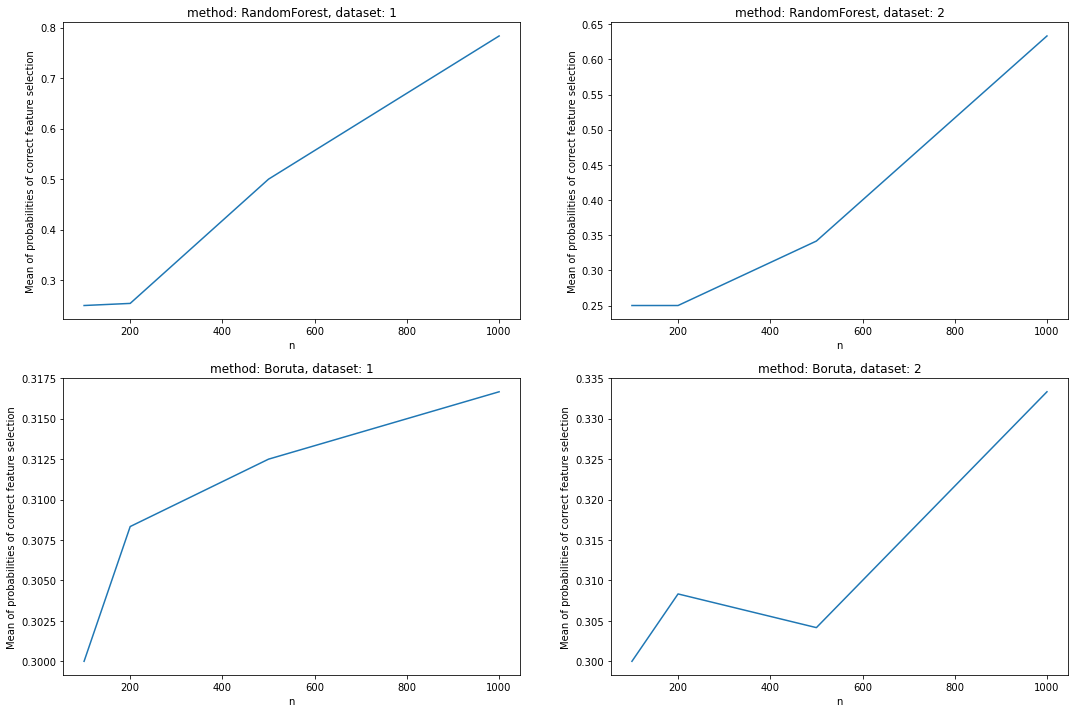

In [15]:
def plot_col(col):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    j = 0
    axs = axs.flatten()
    for method in ['RandomForest', 'Boruta']: 
        for dataset_idx in range(1, 3): 
            tmp_results = results[(results['method'] == method) & (results['dataset'] == dataset_idx)]
            tmp_results_groupped = tmp_results.groupby(col).mean().reset_index()
            axs[j].plot(tmp_results_groupped[col], tmp_results_groupped['probability'])
            axs[j].set_title(f'method: {method}, dataset: {dataset_idx}')
            axs[j].set_ylabel('Mean of probabilities of correct feature selection')
            axs[j].set_xlabel(col)
            j += 1
plot_col('n')

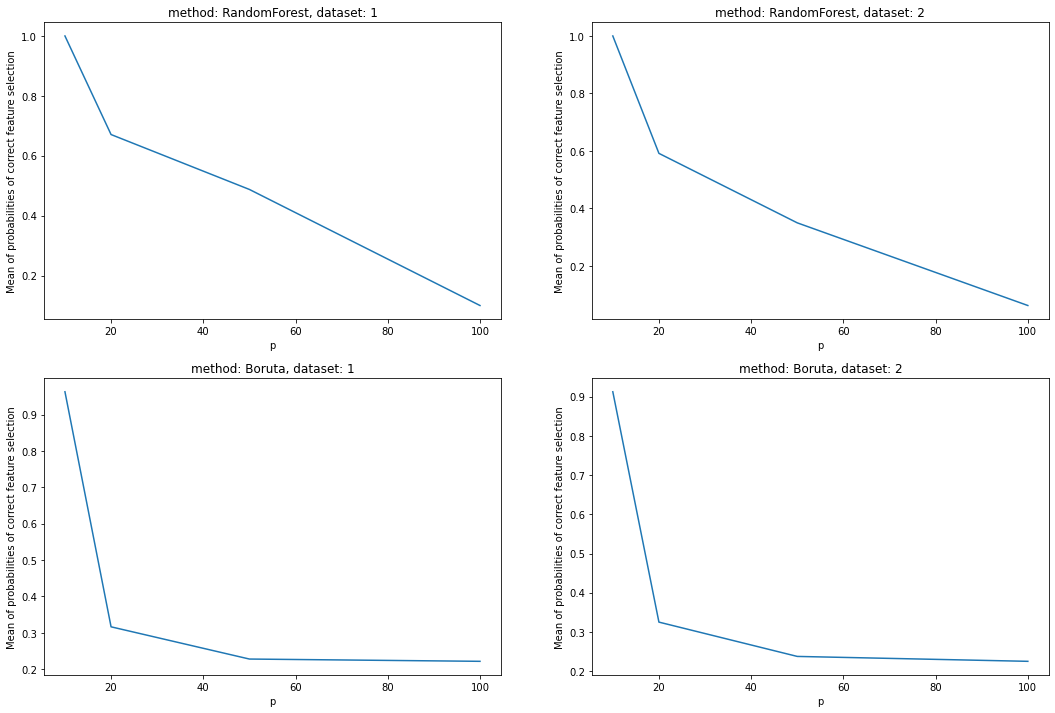

In [16]:
plot_col('p')

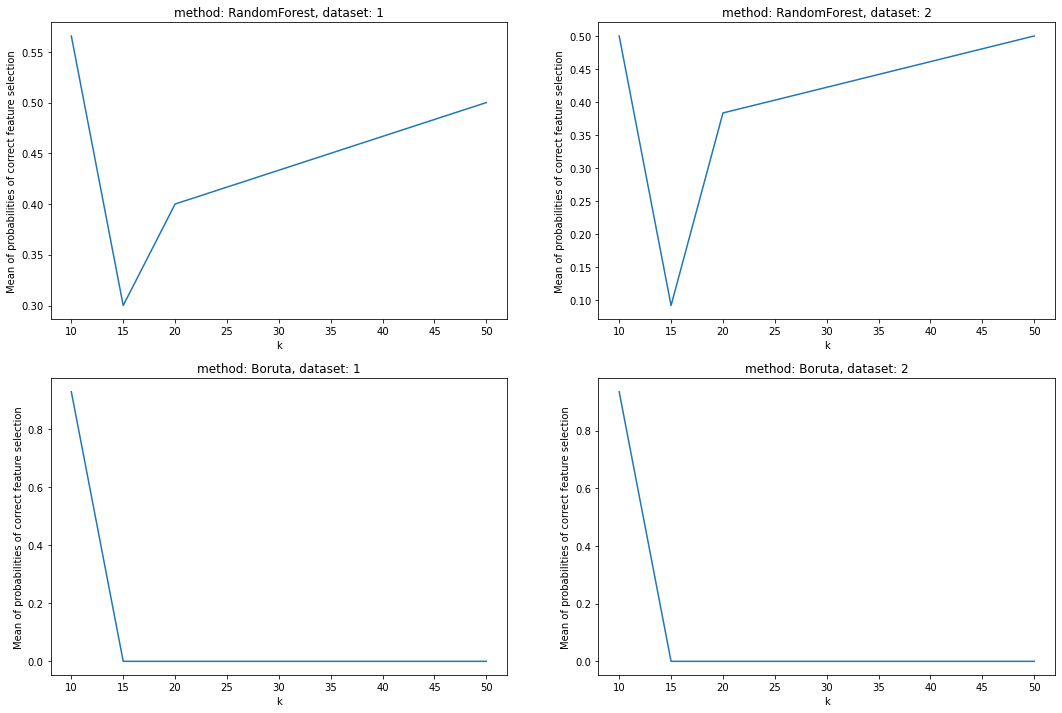

In [17]:
plot_col('k')